In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/vituri/Documentos/GitHub/TDA_workshop_EBT2024"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using Meshes, GeoIO
import GLMakie as gl
using ProgressMeter

In [3]:
read_mesh(filepath) = GeoIO.load(filepath).geometry

plot_mesh(ms) = viz(ms);

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


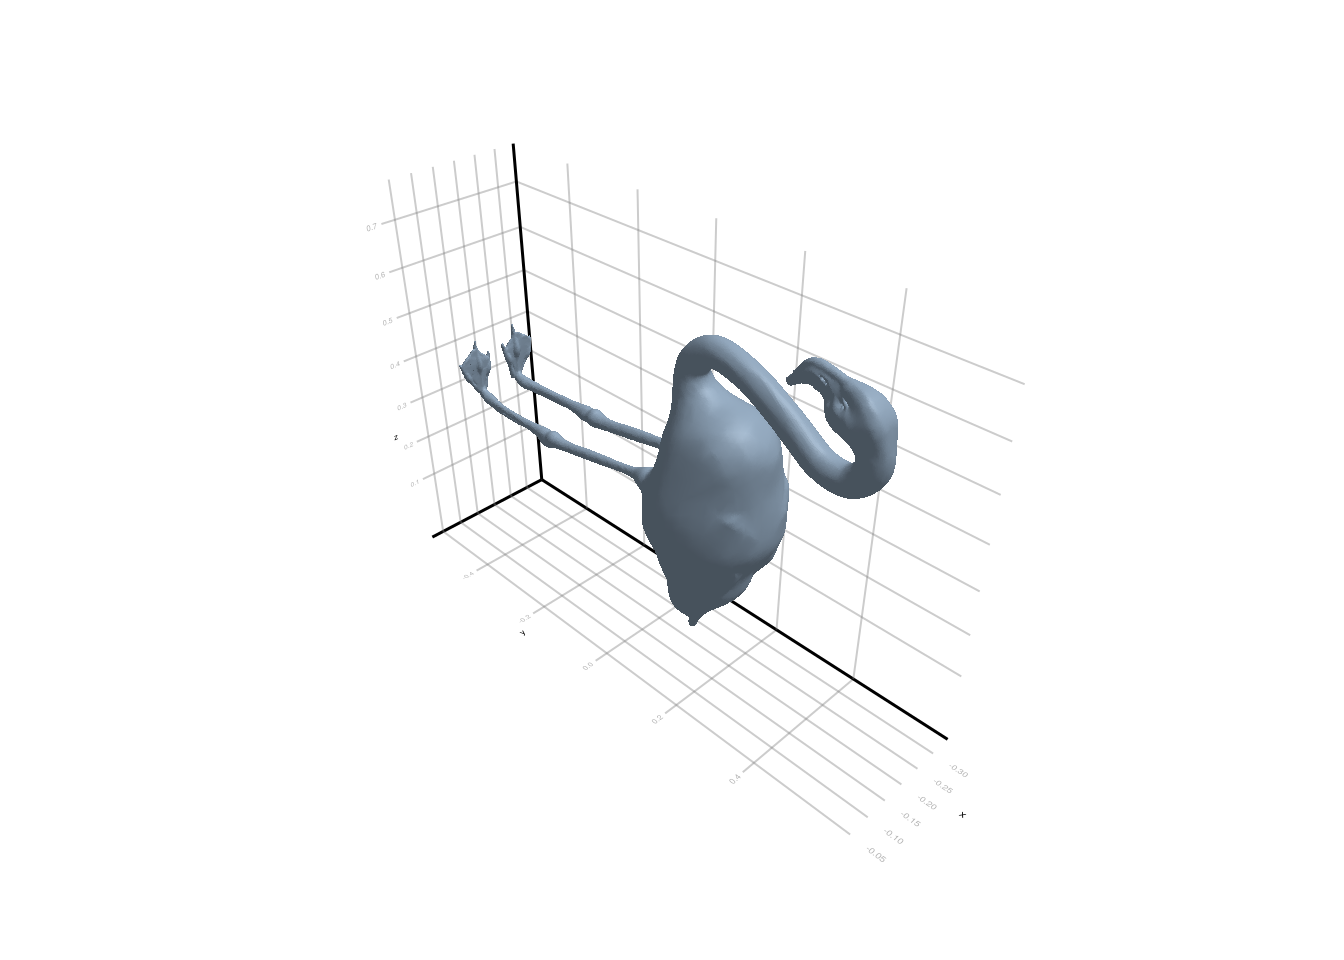

In [4]:
ms = read_mesh("meshes/flamingo-poses/flam-reference.obj")

plot_mesh(ms)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


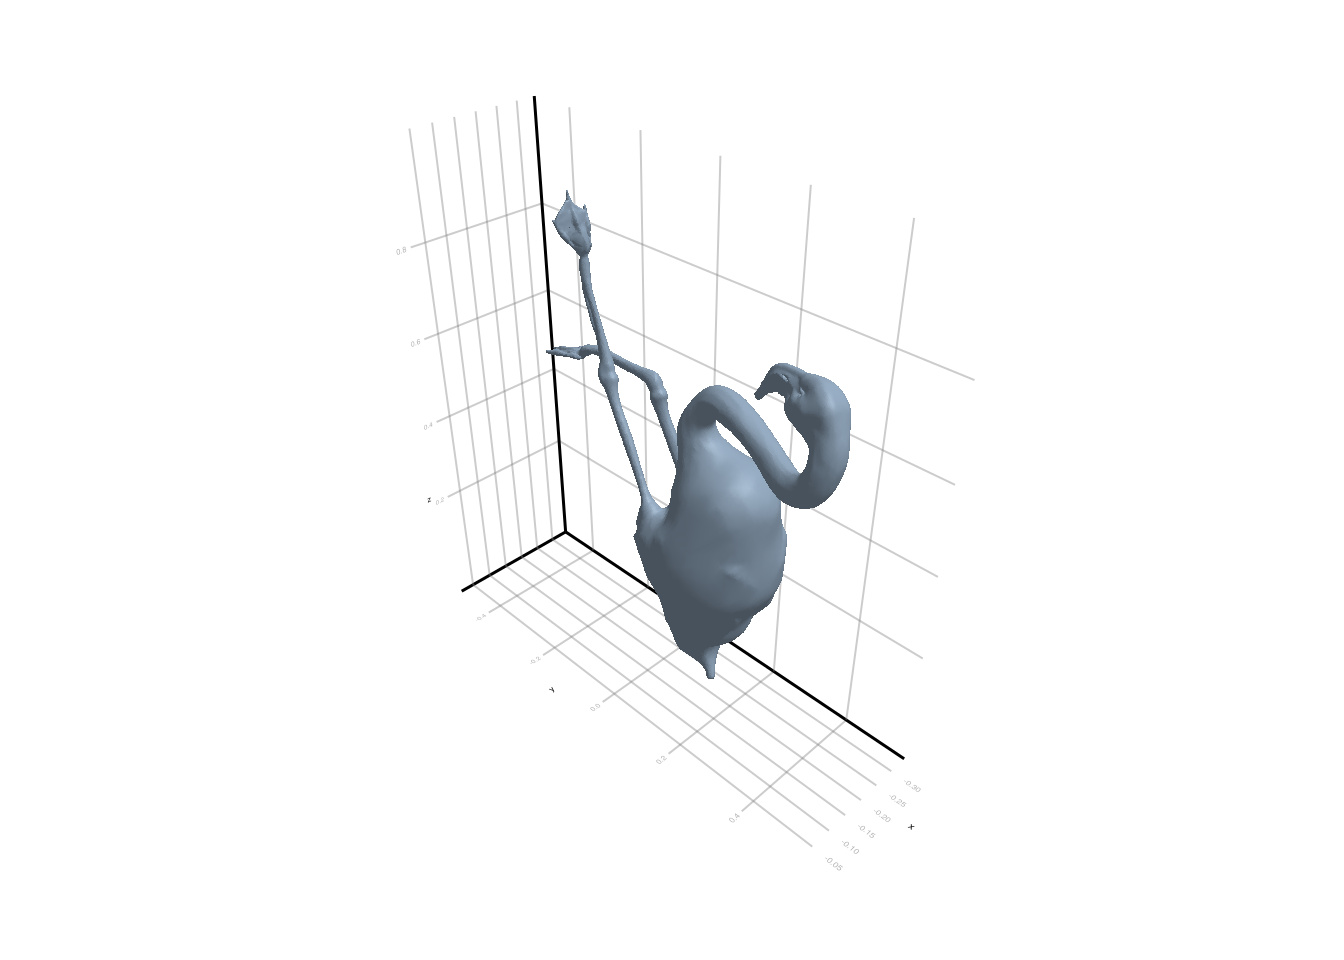

In [5]:
ms = read_mesh("meshes/flamingo-poses/flam-01.obj")

plot_mesh(ms)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


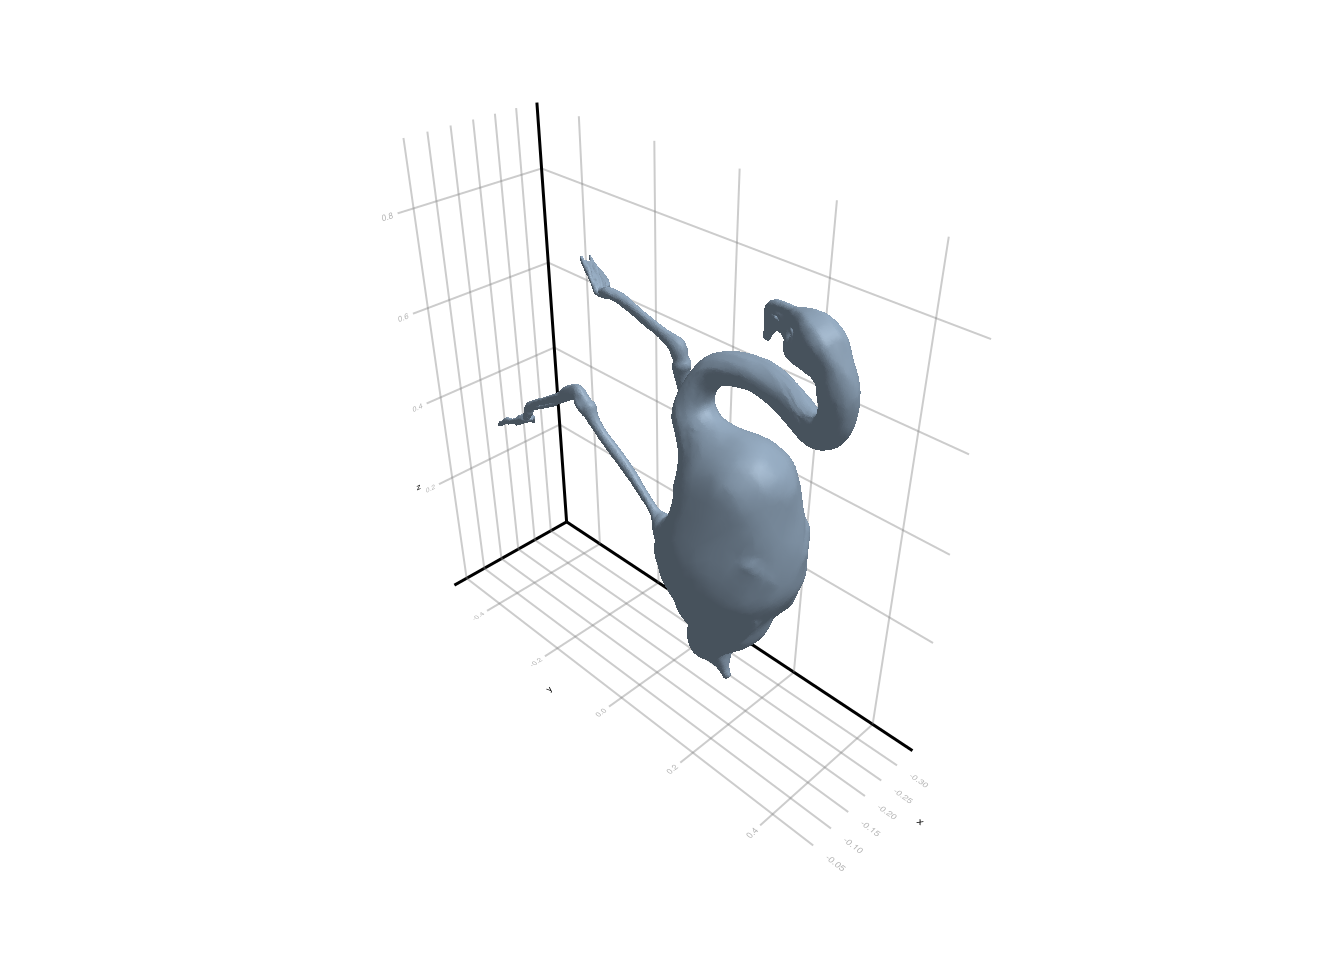

In [6]:
ms = read_mesh("meshes/flamingo-poses/flam-02.obj")

plot_mesh(ms)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


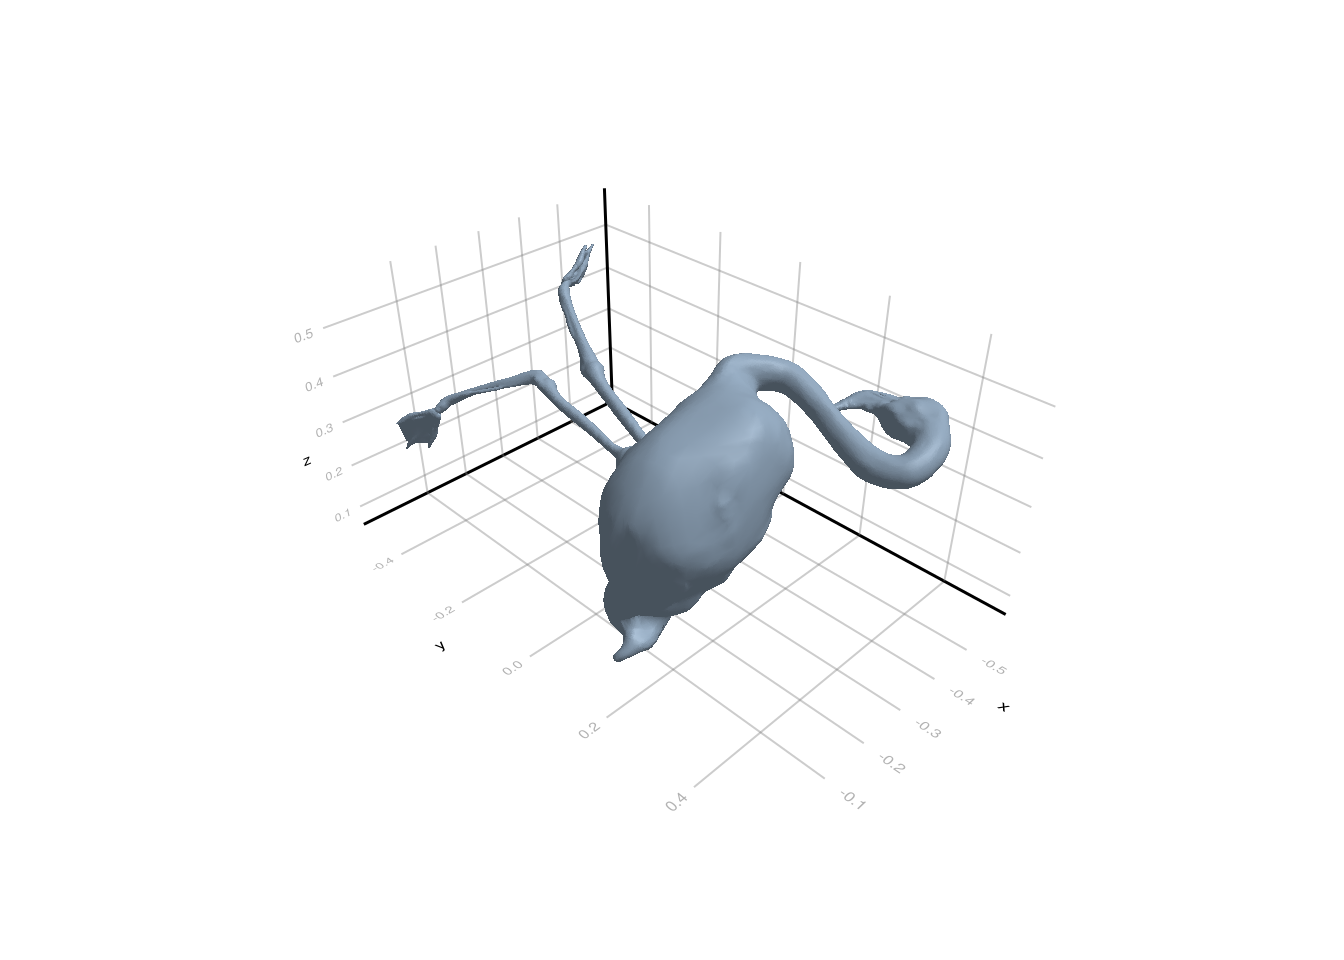

In [7]:
ms = read_mesh("meshes/flamingo-poses/flam-03.obj")

plot_mesh(ms)

In [8]:
readdir("meshes/")

8-element Vector{String}:
 "camel-poses"
 "cat-poses"
 "elephant-poses"
 "face-poses"
 "flamingo-poses"
 "head-poses"
 "horse-poses"
 "lion-poses"

In [9]:
using Graphs, SimpleWeightedGraphs

In [10]:
function mesh_to_graph(ms, X)
    g = SimpleWeightedGraph()
    n = length(X)
    add_vertices!(g, n)

    triangles = ms.topology.connec

    @showprogress desc = "Adding vertices to graph..." for t ∈ triangles
        v1, v2, v3 = t.indices
        add_edge!(g, v1, v2, dist_euclidean(X[v1], X[v2]))

        add_edge!(g, v1, v3, dist_euclidean(X[v1], X[v3]))

        add_edge!(g, v2, v3, dist_euclidean(X[v2], X[v3]))
    end

    g
end

mesh_to_graph (generic function with 1 method)

In [11]:
import DelimitedFiles

using MetricSpaces, Ripserer, PersistenceDiagrams
using Chain

function reduz_obj(arquivo, n_points=1000)
    geotable = GeoIO.load(arquivo)

    X_total = geotable.vertices .|> coordinates .|> Vector |> EuclideanSpace

    ids = farthest_points_sample(X_total, n_points)
    X = X_total[ids]

    arquivo_novo = replace(arquivo, ".obj" => ".csv")
    DelimitedFiles.writedlm(arquivo_novo, stack(X)' |> Matrix, ",")

    X
end

function meshes_to_csv(dir_path)
    for (root, dirs, files) ∈ collect(walkdir(dir_path))
        for file ∈ files
            if occursin(".obj", file)
                arquivo = joinpath(root, file)
                println(arquivo)
                reduz_obj(arquivo)
            end
        end
    end
end



mesh_to_metric_space(ms) = ms.vertices .|> coordinates .|> Vector |> EuclideanSpace

function geodesic_distance_from_graph(g, ids)
    n = length(ids)
    D = zeros(n, n)

    @showprogress desc = "Calculating geodesic distance..." Threads.@threads for (i, id) ∈ collect(enumerate(ids))
        dts = dijkstra_shortest_paths(g, id)
        D[i, :] = dts.dists[ids]
    end

    return D
end

geodesic_distance_from_graph (generic function with 1 method)

In [12]:
# # componentes
# function barcode_from_mesh(ms, n_points=1000)
#     X_total = mesh_to_metric_space(ms)

#     g = mesh_to_graph(ms, X_total)

#     componentes_g = connected_components(g)
#     ids_maior_componente = componentes_g[findmax(length, componentes_g)[2]]

#     X_total = X_total[ids_maior_componente]

#     g = g[ids_maior_componente]


#     fts_sample = farthest_points_sample(X_total, n_points)
#     X = X_total[fts_sample]
#     D = geodesic_distance_from_graph(g, fts_sample)

#     # force simmetry on X
#     for i ∈ 1:n_points
#         for j ∈ i:n_points
#             D[i, j] = D[j, i]
#         end
#     end

#     max_dist = maximum(D)
#     D = D ./ max_dist

#     pd = ripserer(D, dim_max = 2, verbose=true, sparse = true, threshold = 0.9)

#     pd, D, X, g

# end

# pd, D, X, g = barcode_from_mesh(ms, 300)

# exc = mapslices(sum, D, dims=2) |> vec

# gl.scatter(X, color=exc)

# import Plots
# Plots.plot(pd)
# barcode(pd)

In [13]:
# calcula pds
# function list_files(path="", pattern="")
#     files =
#         @chain begin
#             map(walkdir(path)) do (root, dirs, files)
#                 joinpath.(root, files)
#             end
#             reduce(vcat, _)
#             filter(x -> occursin(pattern, x), _)
#         end

#     files
# end

# arquivos = list_files("meshes/", ".obj")

# arquivos = arquivos[1:5:80]

# analises =
#     @showprogress desc="lendo arquivo..." map(arquivos) do file
#         ms = read_mesh(file)
#         pd, D, X, g = barcode_from_mesh(ms)
#     end

# analises[1]
# barcode(analises[1][1])

In [14]:
# arquivos = [
#     "meshes/flamingo-poses/flam-01.obj"
#     ,"meshes/elephant-poses/elephant-01.obj"
# ]

# analises = map(arquivos) do f
#     ms = read_mesh(f)
#     barcode_from_mesh(ms, 350)
# end

# pd, D, X, g = analises[1]
# exc = mapslices(sum, D, dims=2) |> vec
# gl.scatter(X, color=exc)
# barcode(pd)

# pd, D, X, g = analises[2]
# exc = mapslices(sum, D, dims=2) |> vec
# gl.scatter(X, color=exc)
# barcode(pd)

# Bottleneck()(analises[1][1][2:3], analises[2][1][2:3])